## DeepAR Model - Predict Bike Rental with Dynamic Features

Note: This dataset is not a true timeseries as there a lot of gaps

We have data only for first 20 days of each month and model needs to predict the rentals for 
the remaining days of the month. The dataset consists of two years data. DeepAR will shine with true multiple-timeseries dataset like the electricity example given below

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import datetime

import boto3
import sagemaker
from sagemaker import get_execution_role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
# with catories No

with_categories = False

In [21]:
# provide endpoint name details

endpoint_name = 'deepar-biketrain-with-dynamic-feat-2024-06-11-19-51-55-174'

In [4]:
freq = 'H'

# how far we are going to predict for timeseries 12 days

prediction_length = 12*24

# AWS recommends how far past context length same as prediction length
context_length = prediction_length

In [6]:
dt_predict_max = pd.Timestamp("2012-12-31 23:00:00")

dt_dataset_start_time = pd.Timestamp("2011-01-01 00:00:00")
dt_dataset_end_time = pd.Timestamp("2012-12-19 23:00:00")

dt_predict_max, dt_dataset_start_time, dt_dataset_end_time

(Timestamp('2012-12-31 23:00:00'),
 Timestamp('2011-01-01 00:00:00'),
 Timestamp('2012-12-19 23:00:00'))

In [7]:
# use for model_training
# Start time is the first row provided by kaggle
# Training TS end time ensures some data is withheld for model testing
# 12 days worth of training data is withheld for testing

dt_train_range = (dt_dataset_start_time, dt_dataset_end_time - datetime.timedelta(hours=12*24))

# use entire data for testing
# we can compare predicted values vs actual(i.e last 12 days is withheld for testing and model hasen't seen that data

dt_test_range = ( dt_dataset_start_time, dt_dataset_end_time)

In [8]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()

In [9]:
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]  

def encode_dynamic_feat(dynamic_feat):  
    l = []
    for col in dynamic_feat:
        assert (not dynamic_feat[col].isna().any()), col  + ' has NaN'             
        l.append(dynamic_feat[col].tolist())
    return l

def series_to_obj(ts, cat=None, dynamic_feat=None):
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = encode_dynamic_feat(dynamic_feat)
    return obj

def series_to_jsonline(ts, cat=None, dynamic_feat=None):
    return json.dumps(series_to_obj(ts, cat, dynamic_feat))      

In [10]:
# SDK 2. RealTimePredictor renamed to Predictor
class DeepARPredictor(sagemaker.predictor.Predictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        #prediction_times = [x.index[-1]+1 for x in ts]
        prediction_times = [x.index[-1] + datetime.timedelta(hours=1) for x in ts] 
        
        req = self.__encode_request(ts, cat, dynamic_feat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, dynamic_feat, encoding, num_samples, quantiles):
        
        instances = [series_to_obj(ts[k], 
                                   cat[k] if cat else None,
                                   dynamic_feat) 
                     for k in range(len(ts))]
        
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            #prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            prediction_index = pd.date_range(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)            
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [31]:
# SDK 2 parameter name endpoint_name, content_type is specified as part of the serializer

predictor = DeepARPredictor(
    endpoint_name = endpoint_name,
    sagemaker_session=sagemaker_session
)

predictor.set_prediction_parameters(freq,prediction_length)
predictor.serializer.content_type ='application/json'

In [11]:
df = pd.read_csv('all_data_dynamic_feat.csv',parse_dates=['datetime'],index_col=0)
df_test = pd.read_csv('test.csv', parse_dates=['datetime'], index_col=0)

In [12]:
df = df.resample('1h').mean()

In [26]:
dynamic_features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
target_values = ['count','registered','casual']

time_series_test =[]
time_series_training=[]

for t in target_values:
    time_series_test.append(df[dt_test_range[0]:dt_test_range[1]][t])
    time_series_training.append(df[dt_train_range[0]:dt_train_range[1]][t])

df_dynamic_feat = df[dynamic_features]
dynamic_features_test = df_dynamic_feat[dt_test_range[0]:dt_test_range[1]]
dynamic_features_training = df_dynamic_feat[dt_train_range[0]:dt_train_range[1]]

In [27]:
df_dynamic_feat.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-01 00:00:00,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0
2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0
2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0
2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0
2011-01-01 04:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0


In [28]:
dynamic_features_test.shape

(17256, 8)

In [29]:
dynamic_features_training.shape

(16968, 8)

In [32]:
# provide 0 ased index for categories

list_of_df = predictor.predict(time_series_training, 
                               cat=[[0],[1],[2]] if with_categories else None,
                               dynamic_feat=dynamic_features_test
                              )

In [33]:
for i in range(len(list_of_df)):
    print(len(list_of_df[i]))

288
288
288


### Predict total count, registered, casual - We can also predict only on the total count time series

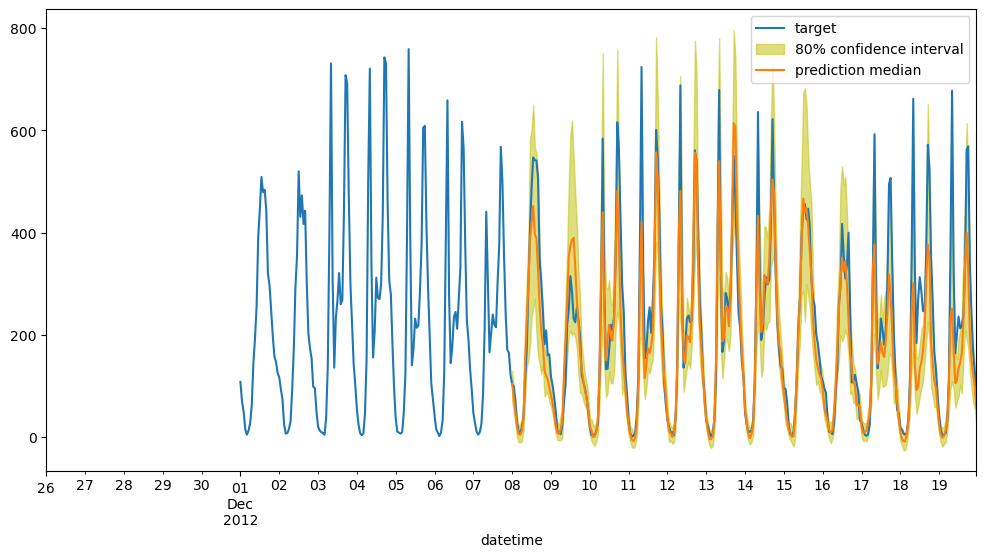

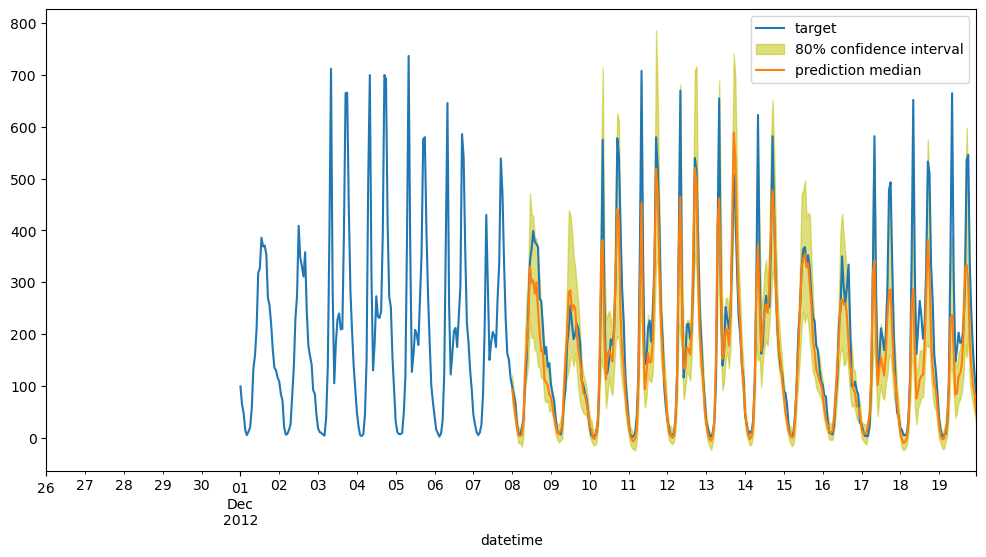

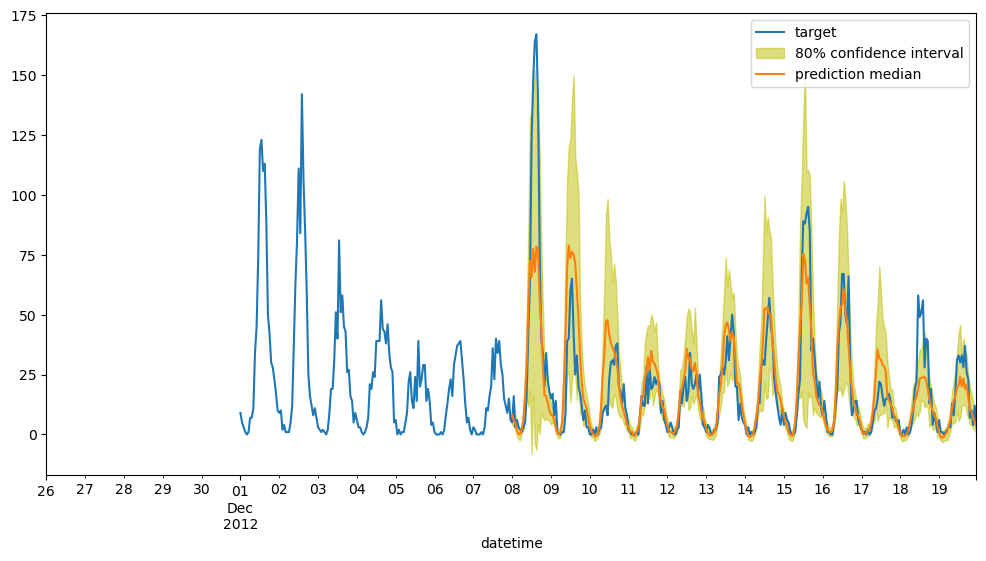

In [35]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    time_series_test[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

In [36]:
predict_window=[]

In [37]:
for i,x in df_test.groupby([df_test.index.year, df_test.index.month]):
    predict_window.append(x.index.min()-datetime.timedelta(hours=1))

In [40]:
target_values

['count', 'registered', 'casual']

In [46]:
for t in target_values:
    df_test[t]=np.nan

In [47]:
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,registered,casual
datetime,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,NaN,NaN,NaN
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,NaN,NaN,NaN
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,NaN,NaN,NaN
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,NaN,NaN,NaN
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,NaN,NaN,NaN


In [48]:
for window in predict_window:
    print(window)
    # if trained with categories, we need to send corresponding category for each training set
    for i in range(len(target_values)):
        list_of_df = predictor.predict([time_series_test[i][:window]],
                                          cat=[i] if with_categories else None,
                                           dynamic_feat=df_dynamic_feat[:window + 
                                                        datetime.timedelta(hours=prediction_length)]
                                      )
        df_tmp = list_of_df[0]
        df_tmp.index_name = 'datetime'
        df_tmp.columns = ['0.1',target_values[i],'0.9']
        df_test.update(df_tmp[target_values[i]])

2011-01-19 23:00:00
2011-02-19 23:00:00
2011-03-19 23:00:00
2011-04-19 23:00:00
2011-05-19 23:00:00
2011-06-19 23:00:00
2011-07-19 23:00:00
2011-08-19 23:00:00
2011-09-19 23:00:00
2011-10-19 23:00:00
2011-11-19 23:00:00
2011-12-19 23:00:00
2012-01-19 23:00:00
2012-02-19 23:00:00
2012-03-19 23:00:00
2012-04-19 23:00:00
2012-05-19 23:00:00
2012-06-19 23:00:00
2012-07-19 23:00:00
2012-08-19 23:00:00
2012-09-19 23:00:00
2012-10-19 23:00:00
2012-11-19 23:00:00
2012-12-19 23:00:00


In [49]:
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,registered,casual
datetime,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,16.359608,14.619929,0.959390
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,8.761232,8.977247,0.329048
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,5.999157,5.743727,0.238405
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,4.095270,3.975657,0.157009
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4.086207,3.504708,0.058459


In [50]:
df_test.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,registered,casual
datetime,,,,,,,,,,,
2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,226.192032,215.756287,9.320799
2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,140.488937,132.422470,8.574405
2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,99.365631,94.807327,6.722708
2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,64.241371,63.442463,5.658419
2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,38.289120,36.063141,4.104802


In [51]:
def adjust_count(x):
    if x < 0:
        return 0
    else:
        return x

In [52]:
df_test['count'] =df_test['count'].map(adjust_count)
df_test['registered'] = df_test['registered'].map(adjust_count)
df_test['casual'] =df_test['casual'].map(adjust_count)

In [53]:
df_reg_cas = pd.DataFrame(df_test['registered']+df_test['casual'])

In [54]:
df_reg_cas.columns=['count']

In [55]:
df_reg_cas.head()

,count
datetime,
2011-01-20 00:00:00,15.579319
2011-01-20 01:00:00,9.306296
2011-01-20 02:00:00,5.982132
2011-01-20 03:00:00,4.132667
2011-01-20 04:00:00,3.563168


In [56]:
# save the result in file
df_test[['count']].to_csv('prediction-with-dynamic-features.csv', index=True, index_label='datetime')

In [57]:
df_reg_cas[['count']].to_csv('prediction-with-dynamic-features-reg-cas.csv', index=True, index_label='datetime')

In [ ]:
# Delete the endpoint
predictor.delete_endpoint()